In [35]:
import pandas as pd
import keras
import utils
from keras.models import model_from_yaml
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
import numpy as np
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)

%matplotlib inline

In [166]:
# load data
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
data = {
    'tra': pd.read_csv('{}/air_visit_data.csv'.format(data_dir)),
    # 'tes': pd.read_csv('{}/sample_submission.csv'.format(data_dir)),
    'as': pd.read_csv('{}/air_store_info.csv'.format(data_dir)),
    'hs': pd.read_csv('{}/hpg_store_info.csv'.format(data_dir)),
    'ar': pd.read_csv('{}/air_reserve.csv'.format(data_dir)),
    'hr': pd.read_csv('{}/hpg_reserve.csv'.format(data_dir)),
    'id': pd.read_csv('{}/store_id_relation.csv'.format(data_dir)),
    'hol': pd.read_csv('{}/date_info.csv'.format(data_dir))
}
# Prepare store info
data['as'] = data['as'].rename({'latitude': 'air_latitude', 'longitude': 'air_longitude'}, axis='columns')
data['hs'] = data['hs'].rename({'latitude': 'hpg_latitude', 'longitude': 'hpg_longitude'}, axis='columns')
stores = pd.merge(data['as'],  data['id'], how='left' )
stores = pd.merge(stores,  data['hs'], how='left')
# only use air_store_id
stores = stores.drop(columns=['hpg_store_id'])

# Prepare static of stores
key = 'air_store_id'
agg = data['tra'].groupby(key).agg([np.min, np.max, np.mean, np.std]).rename(
  columns={
    'amin': 'min_{}'.format('visits'),
    'amax': 'max_{}'.format('visits'),
    'mean': 'mean_{}'.format('visits'),
    'std': 'std_{}'.format('visits')
})
agg.reset_index(inplace=True)
agg.columns = agg.columns.droplevel()
agg = agg.reset_index()
agg.rename(
    {
        '': key,
}, axis='columns', inplace=True)

#merge store statics into store info
stores = pd.merge(stores, agg)

In [4]:
stores.to_csv('./insight/store_stas.csv')

In [66]:
with open('result/model_bn.yml') as file_obj:
    model_yml = file_obj.read()

In [67]:
model = model_from_yaml(model_yml)

In [68]:
model.load_weights('result/model_bn_yy.h5')

In [5]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
feas = utils.data2fea(trn, data_dir)
input_map = feas['x_map']
y = feas['y']
contin_cols = feas['contin_cols']
cat_map_fit = feas['cat_map_fit']
ts_date = feas['times']
s_i = ts_date[ts_date == '2016-04-23'].index[0]
e_i = ts_date[ts_date == '2016-06-01'].index[0]
# valid & trn splitting
map_train, map_valid, y_train_orig, y_valid_orig = utils.ts_data_split(input_map, y, s_i, e_i)
y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)

/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  store_info.drop_duplicates(inplace=True)
/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  hpg_store_info.drop('src', axis=1, inplace=True, errors="ignore")
/usr/local/lib64/python3.6/s

In [31]:
pred_valid = model.predict(map_valid)
# pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y/2)*2

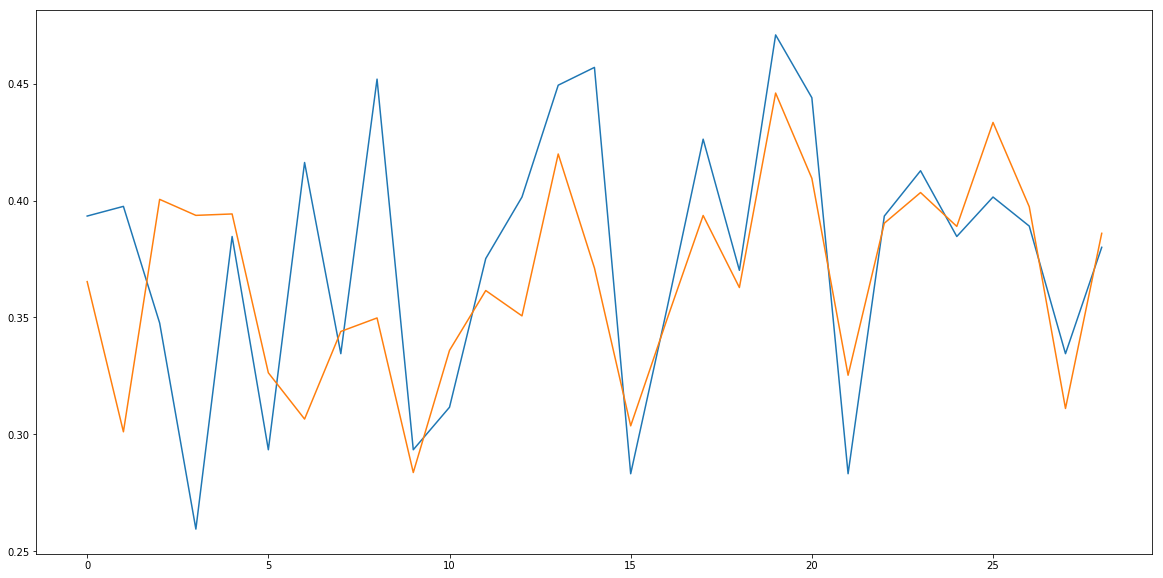

In [32]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid.values)
plt.plot(pred_valid.flatten())

In [33]:
pred_trn = model.predict(map_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)

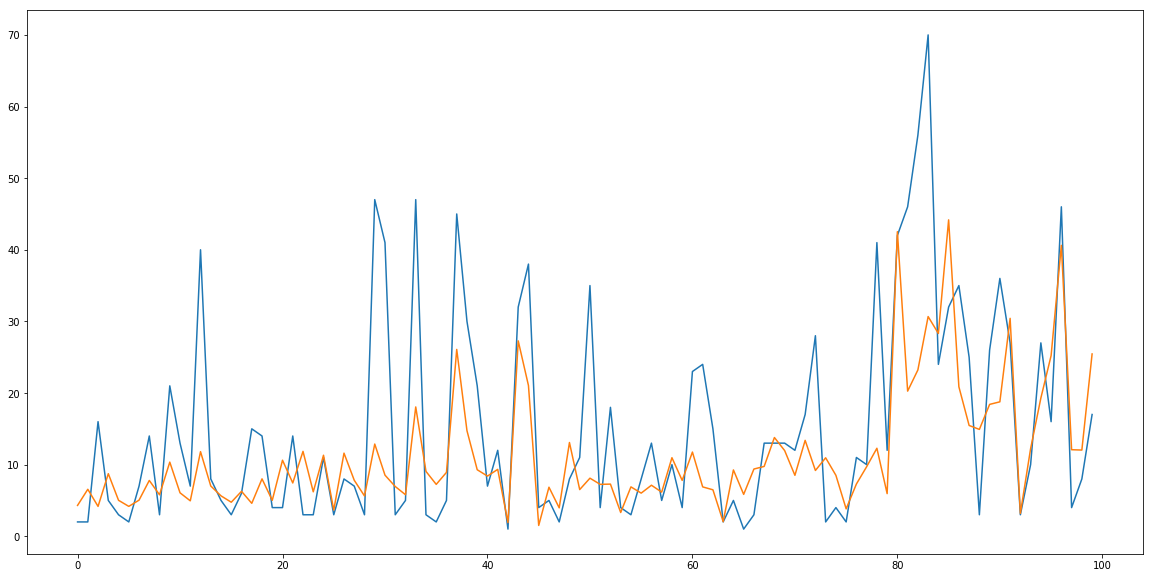

In [34]:
# edge s_p = 13100
s_p = 15200
win_len = 100

plt.figure(figsize=(20, 10))
plt.plot(y_train_orig[s_p:s_p+win_len])
plt.plot(pred_trn_orig[s_p:s_p+win_len].flatten())

In [39]:
map_train[11]

array([[-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.23305971,
         0.16854959,  0.07280731],
       ..., 
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045],
       [-0.78972417, -0.79253807, -0.27968274, ..., -0.74194521,
        -1.43548391, -1.44901045]])

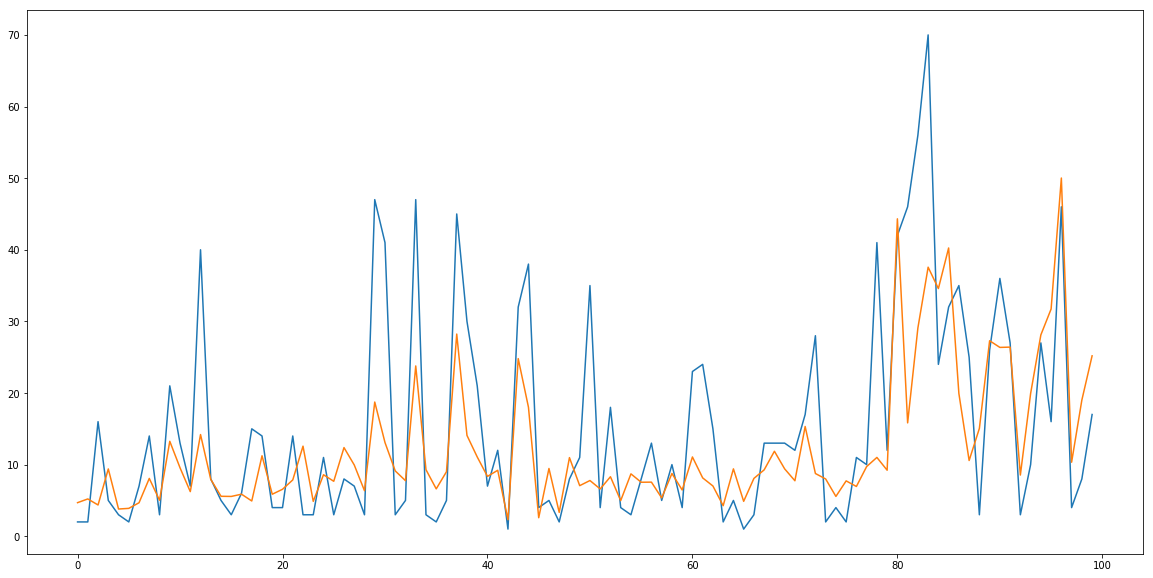

In [51]:

# edge s_p = 13100
s_p = 15200
win_len = 100

plt.figure(figsize=(20, 10))
plt.plot(y_train_orig[s_p:s_p+win_len])
plt.plot(pred_trn_orig[s_p:s_p+win_len].flatten())

(array([  2.51098000e+05,   9.31000000e+02,   3.30000000e+01,
          9.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   88.6,  176.2,  263.8,  351.4,  439. ,  526.6,  614.2,
         701.8,  789.4,  877. ]),
 <a list of 10 Patch objects>)

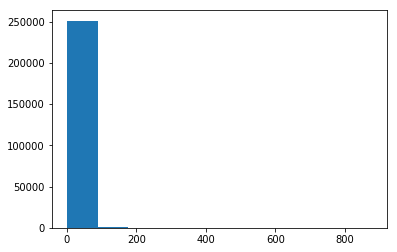

In [17]:
plt.hist(y_train_orig)

(array([  4.81100000e+03,   1.36420000e+04,   3.29410000e+04,
          6.41440000e+04,   7.52910000e+04,   5.37180000e+04,
          7.26700000e+03,   2.38000000e+02,   2.20000000e+01,
          5.00000000e+00]),
 array([ 0.  ,  0.08,  0.16,  0.24,  0.32,  0.4 ,  0.48,  0.56,  0.64,
         0.72,  0.8 ]),
 <a list of 10 Patch objects>)

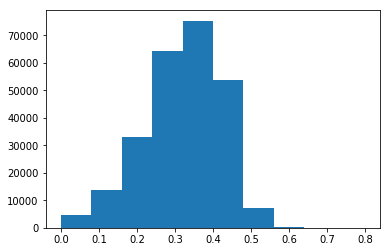

In [18]:
plt.hist(y_train)

(array([  1.73200000e+03,   1.83500000e+03,   4.14500000e+03,
          1.25570000e+04,   1.43593000e+05,   6.70450000e+04,
          1.77280000e+04,   3.21000000e+03,   2.08000000e+02,
          2.60000000e+01]),
 array([  7.62157072e-07,   6.63138991e-02,   1.32627036e-01,
          1.98940173e-01,   2.65253310e-01,   3.31566447e-01,
          3.97879584e-01,   4.64192720e-01,   5.30505857e-01,
          5.96818994e-01,   6.63132131e-01]),
 <a list of 10 Patch objects>)

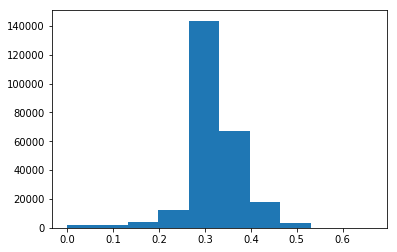

In [19]:
plt.hist(pred_trn)

In [78]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
feas = utils.data2fea(trn, data_dir)

In [79]:
trn_like_test.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,100
1,air_00a91d42b08b08d9,2017-04-24,100
2,air_00a91d42b08b08d9,2017-04-25,100
3,air_00a91d42b08b08d9,2017-04-26,100
4,air_00a91d42b08b08d9,2017-04-27,100


array([ 70.,  16.,  30., ...,  21.,  65.,  74.])

# Submission

In [84]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = np.round(np.random.rand(len(trn_like_test)) * 100))
feas = utils.data2fea(trn_like_test, data_dir)
input_map = feas['sk_fea']
y = feas['y']

In [70]:
pred_test = model.predict(input_map)
pred_test_orig = utils.log_max_inv(pred_test, max_log_y)
# pred_test_orig[pred_test_orig>1000] = pred_test_orig[pred_test_orig<1000].mean()

ValueError: Error when checking model : the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 13 array(s), but instead got the following list of 12 arrays: [array([[ 6],
       [ 6],
       [ 6],
       ..., 
       [12],
       [12],
       [12]]), array([[32],
       [32],
       [32],
       ..., 
       [64],
       [64],
       [64]]), array([[15],
...

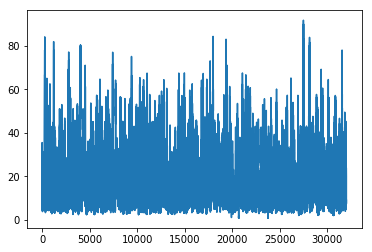

In [22]:
plt.plot(pred_test_orig)

In [23]:
test.visitors = pred_test_orig

In [24]:
test.to_csv('result/submission.csv', index=False)

# Explore results

In [52]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
feas = utils.data2fea(trn, data_dir)
input_map = feas['x_map']
y = feas['y']

/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  store_info.drop_duplicates(inplace=True)
/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/ec2-user/ai/ml_utils/proj/RRVF/utils.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  hpg_store_info.drop('src', axis=1, inplace=True, errors="ignore")


In [53]:
pred_trn = model.predict(input_map)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn = trn.assign(pred=pred_trn_orig)
trn = trn.assign(diff_val=np.abs(trn.pred - trn.visitors))
trn = trn.assign(diff_ratio=np.divide(trn.diff_val, trn.visitors))

In [82]:
DataFrameSummary(trn).summary()

,air_store_id,visit_date,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
count,NaN,NaN,252108,252108,252108,252108,252108,252108,252108,252108,252108
mean,NaN,NaN,20.9738,25.001,3.01968,2016.31,6.2082,19.4187,5.84301,5.84301,0.424395
std,NaN,NaN,16.757,16.0084,1.92399,0.461542,3.68026,13.8287,7.65068,7.65068,0.769973
min,NaN,NaN,1,1,0,2016,1,1,0,0,0
25%,NaN,NaN,9,10,1,2016,3,9.00508,1.69926,1.69926,0.118536
50%,NaN,NaN,17,26,3,2016,7,16.0588,3.86901,3.86901,0.252894
75%,NaN,NaN,29,39,5,2017,10,26.3859,7.63295,7.63295,0.449575
max,NaN,NaN,877,53,6,2017,12,206.999,859.973,859.973,32.3515
counts,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108,252108
uniques,829,478,204,53,7,2,12,248368,249496,249496,251244


In [83]:
agg = trn.groupby('air_store_id').mean()

In [85]:
agg = agg.sort_values('diff_ratio')

In [88]:

DataFrameSummary(agg).summary()

,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
count,829,829,829,829,829,829,829,829,829
mean,21.2039,25.43,3.02443,2016.33,6.30872,19.6738,5.85496,5.85496,0.423868
std,11.775,3.32288,0.302565,0.120549,0.765667,11.6707,2.78625,2.78625,0.156497
min,1.1875,10.3667,2.03191,2016,2.83333,1.00132,0.188525,0.188525,0.0723492
25%,11.812,22.4159,2.91039,2016.24,5.60403,10.6193,3.90871,3.90871,0.311818
50%,19.1834,27.4475,3.02114,2016.37,6.77083,17.315,5.4273,5.4273,0.411022
75%,28.6452,27.7973,3.16239,2016.38,6.85659,26.9636,7.2956,7.2956,0.516158
max,115.471,36.1753,4.775,2017,8.78351,112.424,26.8287,26.8287,1.59998
counts,829,829,829,829,829,829,829,829,829
uniques,828,803,760,634,777,829,829,829,829


In [129]:
agg[ (agg.diff_ratio < 0.8) & (agg.diff_ratio > 0.6)].head()

,visitors,visit_date_week,visit_date_dayofweek,visit_date_year,visit_date_month,pred,diff,diff_val,diff_ratio
air_store_id,,,,,,,,,
air_bcce1ea4350b7b72,16.598592,27.665493,3.042254,2016.369718,6.841549,13.892851,6.700159,6.700159,0.601095
air_0164b9927d20bcc3,9.248322,25.335570,2.557047,2016.557047,6.268456,7.322750,4.034711,4.034711,0.601766
air_aed3a8b49abe4a48,9.080000,27.854545,3.061818,2016.360000,6.880000,7.566768,3.612044,3.612044,0.602255
air_ee3ba9af184c6c82,13.348684,31.750000,2.940789,2016.250000,7.776316,10.843468,5.682018,5.682018,0.602320
air_457efe8c3a30ea17,6.909326,22.238342,2.748705,2016.230570,5.577720,5.766316,3.036346,3.036346,0.602718


/usr/local/lib64/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


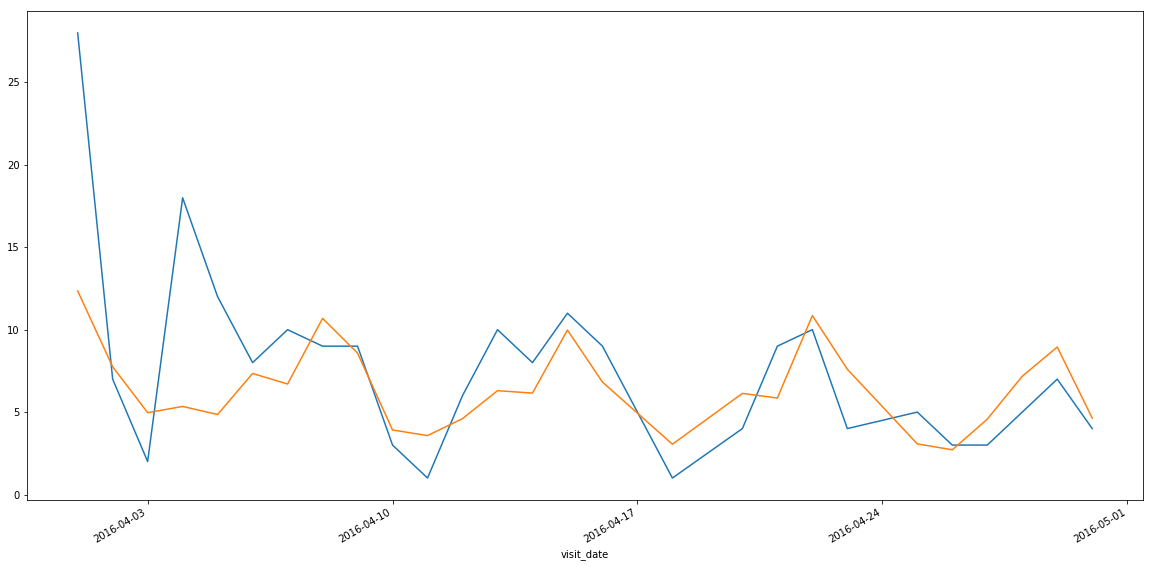

In [140]:
plt.figure(figsize=(20, 10))
a_store = trn[trn.air_store_id == "air_457efe8c3a30ea17"]
a_store.visit_date = pd.to_datetime(a_store.visit_date)
a_store = a_store.set_index('visit_date')
a_store['2016-04'].visitors.plot()
a_store['2016-04'].pred.plot()

# Worst cases

## 点少
- air_52a08ef3efdb4bb0

## 变化幅度大
- air_8e492076a1179383 变化幅度大 20 ~ 100
- air_4c2ed28f3f19ca52 变化幅度大
- air_df507aec929ce5f6
- air_9387ff95e886ebc7

20~50
 - air_22682e965418936f
 - air_3155ee23d92202da
 
Period change
 - air_93dd7070c9bf5453
 
非常奇怪：
air_9828505fefc77d75
 ## 好的
 30 ~ 60 change
 20 ~ 40

# Xgboost